# Prunning of the pretrained object detection model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get data

!rm -rf sample_data
!rm -rf dataset_u1
!mkdir dataset_u1
!7z x -o/content/dataset_u1/ -y -bsp2 "/content/drive/MyDrive/VideoAnalytics/"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/VideoAnalytics/                                                1 folder, 8 files, 2239473340 bytes (2136 MiB)
  0%
Extracting archive: /content/drive/MyDrive/VideoAnalytics/VA_2_Detection/dataset.7z.001
    --
Path = /content/drive/MyDrive/VideoAnalytics/VA_2_Detection/dataset.7z.001
Type = Split
Physical Size = 314572800
Volumes = 8
Total Physical Size = 2239473340
----
Path = dataset.7z
Size = 2239473340
--
Path = dataset.7z
Type = 7z
Physical Size = 2239473340
Headers Size = 212000
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 7 - .001               0% 62 - train/images/010738.jpg

Let's look at examples from train set, and their markup.

Число примеров в тренировочном и валидационном датасетах: 12103 1344


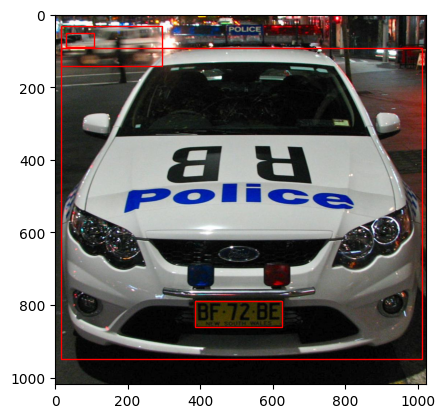

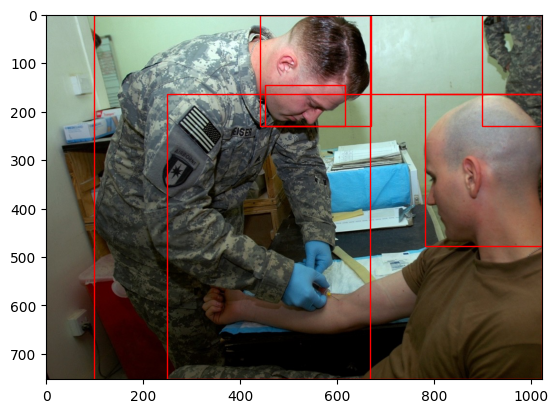

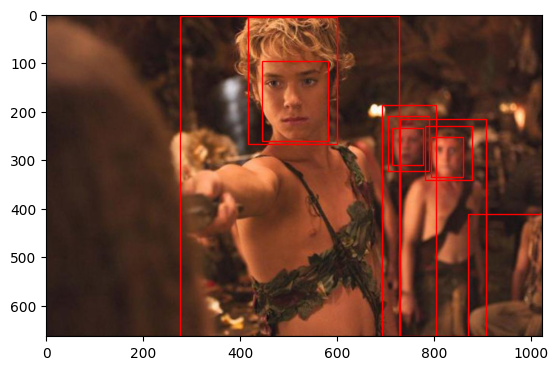

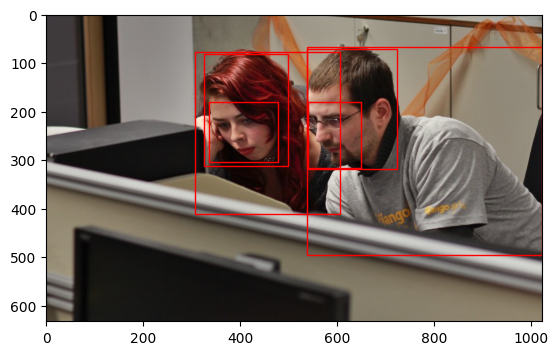

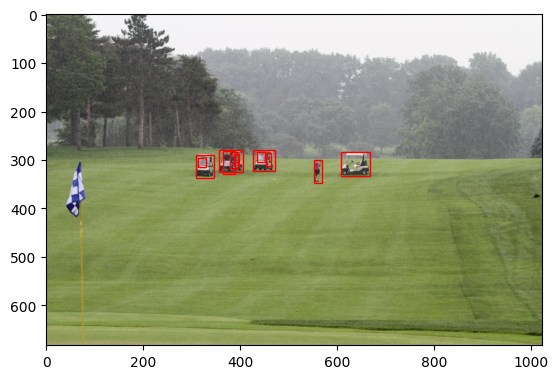

In [ ]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

prefix = 'dataset_u1'

train = sorted(os.listdir(os.path.join(prefix, 'train/images')))
valid = sorted(os.listdir(os.path.join(prefix, 'valid/images')))

images = [mpimg.imread(os.path.join(prefix, f'train/images/{i}')) for i in train[:10]]
labels = []
print('Number of examples in training and validation datasets:', len(train), len(valid))

for item in train[:5]:
    with open(os.path.join(prefix, f'train/labels/{item[:-4]}.txt'), 'r') as f:
        lines = [line.strip() for line in f]
        labels.append(lines)


for item, boxes in zip(images, labels):
    fig, ax = plt.subplots()
    ax.imshow(item)
    for box in boxes:
        items = box.split(' ')
        rect = patches.Rectangle((((float(items[1]) * item.shape[1]) - ((float(items[3]) * item.shape[1]) / 2)),((float(items[2]) * (item.shape[0])) - ((float(items[4]) * item.shape[0]) / 2))),float(items[3]) * item.shape[1], float(items[4]) * item.shape[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

# Atchitecture for training a detector

Additionally, let's install ```pytorch lightning```

In [ ]:
!pip install -q pytorch-lightning==1.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 148.8 kB/s eta 0:00:00


## Datasets

We're going to deal with image detection model. The following dataset does the following:

1. Keep information (index) about the dataset
    * number of images
    * where the images can be found
    * where their markup can be found and what format it has
2. Upload an image with its markup in format of required tensors (by explicit request)

We'll also need a variable ```transforms``` which describes augmentations that should be applied to the validation and train sets.

While training it's important to group images into batches. It means that all images should have the same size. In order to do this, we'll transform train set using such augmentations as `CenterCrop 512, Noramlize, ToTensorV2`.

It's a good practice to do validation on a such data set that is close to train set. It helps to identify overtraining problem. And it means that for validation augmentations should be the same as for training.

But for testing set we keep some images which didn't participate in training or validation. Those images allow us to measure correct matrics. While testing, there shouldn't be used any randomized augmentation because we simulate real usage of the model in a prodution system. At the same time we usually deal with stream of data instead of batches, that's why we need to process images one by one. But we still need to be sure that image size is deveded by 32 (because we have MaxPooling at the model's architecture).

In [ ]:
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2

transforms = {
    "train": A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.Blur(blur_limit=3),
            A.PadIfNeeded(
                min_height=512, min_width=512
            ),  # pad_height_divisor=32, pad_width_divisor=32),
            A.CenterCrop(512, 512),
            #A.RandomResizedCrop(512, 512),
            A.Normalize(
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"], min_visibility=0.3
        ),
    ),
    "valid": A.Compose(
        [
            A.SmallestMaxSize(512, always_apply=True),
            #A.CenterCrop(512, 512),
            A.PadIfNeeded(
                min_height=None,
                min_width=None,
                pad_height_divisor=32,
                pad_width_divisor=32,
            ),
            A.Normalize(
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"], min_visibility=0.3
        ),
    ),
    "test": A.Compose(
        [
            A.SmallestMaxSize(512, always_apply=True),
            A.PadIfNeeded(
                min_height=None,
                min_width=None,
                pad_height_divisor=32,
                pad_width_divisor=32,
            ),
            A.Normalize(
                p=1.0,
            ),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"], min_visibility=0.3
        ),
    ),
}

In [ ]:
from torch.utils.data import DataLoader, Dataset
import glob
import cv2
import numpy as np
import xml.etree.ElementTree as et
import torch
from PIL import Image
from scipy.ndimage import gaussian_filter


class DetectionDataset(Dataset):
    def __init__(self,
                 dir_path,
                 classes,
                 transforms=None,
                 cell=8):

        self.transforms = transforms
        self.dir_path = dir_path
        self.classes = classes
        self.cell = cell

        # path to whole list of images in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}images/*.jpg")
        self.image_paths = sorted(self.image_paths)
        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in self.image_paths
        ]
        self.all_images = sorted(self.all_images)
        # getting file name in sorted order
        self.labels_paths = glob.glob(f"{self.dir_path}labels/*.txt")
        self.labels_paths = sorted(self.labels_paths)
        self.all_targets = [
            labels_paths.split(os.path.sep)[-1] for labels_paths in self.labels_paths
        ]
        self.all_targets = sorted(self.all_targets)
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        # upload image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        height = image.shape[0]
        width = image.shape[1]
        # upload markup
        labels_path = self.labels_paths[idx]
        labels = [line.rstrip() for line in open(labels_path)]

        target = {}
        target["bboxes"] = []
        target["labels"] = []

        for data in labels:
            x, y, w, h = [float(x) for x in data[1:].split()]
            label = int(data[0])

            points = np.array([x - w / 2, y - h / 2, x + w / 2, y + h / 2])

            points = np.clip(points, 0, 1)

            points[[0, 2]] = np.sort(points[[0, 2]]) * width
            points[[1, 3]] = np.sort(points[[1, 3]]) * height

            if self.classes[label] in ["car", "plate"]:
                target["bboxes"].append(points)
                target["labels"].append(label)

        transformed = self.transforms(
            image=image, bboxes=target["bboxes"], labels=target["labels"]
        )

        transformed_img = transformed["image"]
        transformed_bbox = {
            "bboxes": transformed["bboxes"],
            "labels": transformed["labels"],
        }
        width = transformed_img.shape[2]
        height = transformed_img.shape[1]

        car_target = torch.zeros(5, height // self.cell, width // self.cell)
        plate_target = torch.zeros(5, height // self.cell, width // self.cell)

        for box, label in zip(transformed_bbox["bboxes"], transformed_bbox["labels"]):
            self.classes[label]
            x_center = (box[1] + box[3]) / 2 / self.cell
            y_center = (box[0] + box[2]) / 2 / self.cell

            x_cell, y_cell = int(x_center),  int(y_center)

            x_shift, y_shift = x_center - x_cell ,y_center - y_cell

            box_wdh = np.log(np.abs(box[2] - box[0]) / self.cell)
            box_hei = np.log(np.abs(box[3] - box[1]) / self.cell)

            if self.classes[label] == "car":
                car_target[:, x_cell, y_cell] = torch.tensor(
                    [1, y_shift, x_shift, box_hei, box_wdh]
                )

            if self.classes[label] == "plate":
                plate_target[:, x_cell, y_cell] = torch.tensor(
                    [1, y_shift, x_shift, box_hei, box_wdh]
                )

        return {
            "img": transformed_img,
            "targ": torch.cat([car_target, plate_target], dim=0),
        }

### Datasets' initialization

In [ ]:
import yaml

stream = open("/content/dataset_u1/data.yaml", "r")
config = yaml.safe_load(stream)

train_ds = DetectionDataset(
    '/content/dataset_u1/train/',
    classes=config['names'],
    transforms=transforms['train']
)

test_ds = DetectionDataset(
    '/content/dataset_u1/valid/',
    classes=config['names'],
    transforms=transforms['valid']
)

### Decoding NN's predictions and testing of the dataset

The following function does a reversed opertion in comparison with forming required (input) tensors. It looks at presence maps and for those cells where probability of object presence is higher than a threshold, it calculates shift and size of the object.

In [ ]:
print(len(train_ds))
import numpy
import torchvision

def decode_result(datum, threshold=1.0, r=8, iou_threshold=0.7):
    bboxes = {'boxes': [], 'scores': [], 'labels': []}
    datum = {0: datum[:5, :, :],
             1: datum[5:, :, :]}

    for label in [0, 1]:
        mask = (datum[label][0, :, :] >= threshold)

        x_cell = torch.arange(mask.shape[1], device=datum[label].device)
        y_cell = torch.arange(mask.shape[0], device=datum[label].device)

        y_cell, x_cell = torch.meshgrid(y_cell, x_cell)

        x_cell = x_cell[mask]
        y_cell = y_cell[mask]

        x_shift = datum[label][2, :, :][mask]
        y_shift = datum[label][1, :, :][mask]

        x = (x_cell + x_shift) * r
        y = (y_cell + y_shift) * r

        w = datum[label][4, :, :][mask].exp() * r
        h = datum[label][3, :, :][mask].exp() * r

        scores = datum[label][0, :, :][mask]


        for index in range(len(x)):
            bboxes['boxes'].append([x[index] - w[index]/2,
                         y[index] - h[index]/2,
                         x[index] + w[index]/2,
                         y[index] + h[index]/2])
            bboxes['scores'].append(scores[index])
            bboxes['labels'].append(label)

    bboxes['boxes'] = torch.tensor(bboxes['boxes']).reshape([-1, 4])
    bboxes['scores'] = torch.tensor(bboxes['scores'])
    bboxes['labels'] = torch.tensor(bboxes['labels'])

    to_keep = torchvision.ops.nms(bboxes['boxes'], bboxes['scores'], iou_threshold=iou_threshold)

    bboxes['boxes'] = bboxes['boxes'][to_keep]
    bboxes['scores'] = bboxes['scores'][to_keep]
    bboxes['labels'] = bboxes['labels'][to_keep]

    return bboxes


def decode_batch(batch, threshold=0.5, iou_threshold=0.3):
    res = []
    for index in range(batch.shape[0]):
        res.append(decode_result(batch[index],
                   threshold=threshold,
                   iou_threshold=iou_threshold))
    return res


12103


### Target visualization

tensor(-2.1179) tensor(2.6400)
torch.Size([3, 512, 512])
torch.Size([10, 64, 64])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


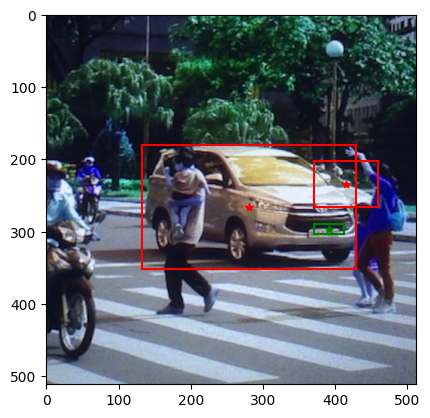

In [ ]:
def draw_box(coords, label):
    x = numpy.array((coords[0], coords[2]))
    y = numpy.array((coords[1], coords[3]))
    color = 'g'
    if label == 0:
        color = 'r'

    plt.plot(x.mean(), y.mean(), '*' + color)

    plt.plot([x[0], x[0]], [y[0], y[1]], color)
    plt.plot([x[1], x[1]], [y[0], y[1]], color)
    plt.plot([x[0], x[1]], [y[0], y[0]], color)
    plt.plot([x[0], x[1]], [y[1], y[1]], color)
    # plt.text(x[0], y[0], label, backgroundcolor='red')


datum = train_ds[400]
img_min, img_max = datum['img'].min(), datum['img'].max()

print(img_min, img_max)
print(datum['img'].shape)
print(datum['targ'].shape)

bboxes = decode_result(datum['targ'])

plt.imshow((datum['img'].permute([1, 2, 0]) - img_min) / (img_max - img_min))

for index in range(len(bboxes['boxes'])):
    draw_box(bboxes['boxes'][index], bboxes['labels'][index])

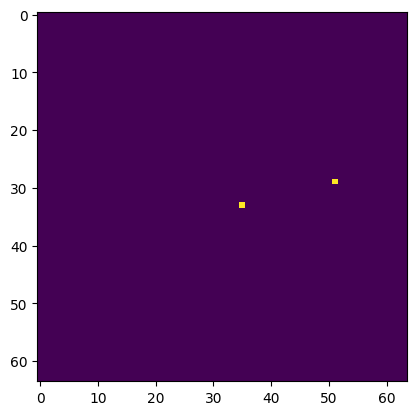

In [ ]:
# centers of the found bounding boxes only
plt.imshow(datum['targ'][0, :, :])

### Preparing dataloaders

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

dl_train = DataLoader(
    train_ds, batch_size=32, num_workers=4, shuffle=True, drop_last=True
)

print(len(test_ds))

dl_test = DataLoader(
    test_ds, batch_size=1, num_workers=4, shuffle=False
    )



1344


### Check that the dataloaders work

In [ ]:
print("Testing train dataloader")
for datum in tqdm(dl_train):
    pass
print("Success")

print("Testing validation dataloader")
for datum in tqdm(dl_test):
    pass
print("Success")

Testing train dataloader


100%|██████████| 378/378 [01:07<00:00,  5.59it/s]


Success
Testing validation dataloader


100%|██████████| 1344/1344 [00:12<00:00, 103.74it/s]

Success


## Neural network's architecture

In our detection task there are just two classes that's why we'll simply train two detectors (one detector per one class).

We have rather small dataset, it means that it's better to use a pretrained detector and finetune it using our data by training new layers only.

As a basic model we'll use pretrained architecture from ```torchvision``` library - ```torchvision.models.detection.retinanet_resnet50_fpn_v2```. But we don't need all activation maps which are generated by the backbone but just one of them (with maximum number of cells for detection, it's ```[0]``` tensor gotten from the backbone).

As a ```head``` of the model we'll use a convolutional layer, or a couple of convolutional layers (depending on what will give a better quality).

As a result, the model should return a tensor with 10 activation maps:

* A car:
    * 0: logit of its presence
    * 1-2: logits of its center
    * 3-4: logarithms of its size
* A plate:
    * 5: logit of its presence
    * 6-7: logits of its center in the cell
    * 8-9: logarithms of its size


In [ ]:
import torchvision
import torch

class RetinaRehead(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
            weights="DEFAULT"
        )
        self.detector = torch.nn.Conv2d(256, 10, kernel_size=3, padding=1)

    def forward(self, input):
        res = self.model.backbone.forward(input)

        res = res["0"]
        res = self.detector.forward(res)
        return res

In [ ]:
model = RetinaRehead()
model.eval()
res = model.forward(torch.zeros(10, 3, 512, 1024))
print(res.shape)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:02<00:00, 53.1MB/s]


torch.Size([10, 10, 64, 128])


## Loss function

In order to write the loss function, we need to define three following loss functions:

* ```loss_object(pred, target)```  - for loss in terms of class logits (sigmoid_focal_loss)
* ```loss_center(pred, target)``` - for loss in terms of object center (binary_cross_entropy_with_logits)
* ```loss_size(pred, target)``` - for loss in terms of width и height of the object (sum of absolut values of deviation).

Usually for losses average values are used (inside a batch). But in our case we prefer to use a sum of losses because loss functions of objects' centers and  their sizes we calculate for those cells where the objects exist.

In [ ]:
from torchvision.ops.focal_loss import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits


def loss_object(pred, targ):
    # Object presence loss
    obj_loss = sigmoid_focal_loss(pred[:, 0, :, :], targ[:, 0, :, :], reduction="sum")
    return obj_loss


def loss_center(pred, targ):
    # Center coordinates loss
    mask = (targ[:, 0, :, :]) >= 1.0
    x_loss = binary_cross_entropy_with_logits(
        pred[:, 1, :, :][mask], targ[:, 1, :, :][mask], reduction="sum"
    )
    y_loss = binary_cross_entropy_with_logits(
        pred[:, 2, :, :][mask], targ[:, 2, :, :][mask], reduction="sum"
    )

    # Wrapping everything up
    return x_loss + y_loss


def loss_size(pred, targ):
    # Width and height loss
    mask = (targ[:, 0, :, :]) >= 1.0
    w_loss = (pred[:, 3, :, :][mask] - targ[:, 3, :, :][mask]).abs().sum()
    h_loss = (pred[:, 4, :, :][mask] - targ[:, 4, :, :][mask]).abs().sum()

    return w_loss + h_loss

## Pytorch Lightning module for training

In [ ]:
#@title Custom ProgressBar Code

import pytorch_lightning as pl
import sys
import math
import time
import datetime
import copy
import numpy
import os

try:
    from IPython.display import display, update_display
except:
    pass

def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        module = get_ipython().__class__.__module__
        if module == "google.colab._shell":
            return True
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False

def nlines(text):
    return text.count('\n') + 1

status = {
    'Info': '5/10 [######9     ] 59%',
    'Time/D': 0.9999999999999999999999,
    'Time/B': 0.1238476123864126345187245,
    'Time/AvgD': 0.812341348176234987162349817643,
    'Time/AvgB': 0.8561283745187634581726345,
    'Loss/L1': 112398746192834619827364,
    'Loss/L2': 19234618623.0,
    'Loss/L2.5': 1,
    'Loss/L3': 0.8126347152,
    'Loss/L4': 10,
    'Loss/L5': numpy.inf,
    'Metrics/One': 0.888888,
    'Metrics/Two': 123987.0,
    'Metrics/Three': 1.0
}


def textcolor(style=None, color=None):
    if color is None:
        color = 0
    else:
        color_code = 30 + color
    if style is None:
        style_code = 0
    else:
        style_code = style
    return '\033[' + str(style_code) + ';' + str(color_code) + 'm', '\033[' + str(0) + ';' + str(0) + 'm'


def format_status(inp):
    if isinstance(inp, (dict)):
        for key in inp:
            inp[key] = format_status(inp[key])

    if isinstance(inp, (list, tuple)):
        for index in range(len(inp)):
            inp[index] = format_status(inp[index])

    if isinstance(inp, torch.Tensor):
        inp = inp.detach().cpu().numpy()

    if isinstance(inp, int):
        if abs(inp) > 10 ** 6:
            return '{:.3e}'.format(inp)
        else:
            return '{:d}'.format(inp)

    if isinstance(inp, float):
        if abs(inp) > 10 ** 6:
            return '{:.3e}'.format(inp)
        elif abs(inp) < 10 ** -6:
            return '{:.3e}'.format(inp)
        else:
            return '{:.6f}'.format(inp)

    return inp


def colorize_string(string, colors, padding=0):
    indice = []
    for color in colors:
        indice.append(colors[0])

    substrings = []
    last_index = 0
    for color in colors:
        index = color[0] + padding
        substrings.append(string[last_index:index])
        substrings.append(color[1])
        last_index = index
    substrings.append(string[last_index:])
    return ''.join(substrings)


def view_status(inp, display_len=80):
    separator = ' | '
    strings = ['']
    colors = [[]]
    color_index = 0

    maxlen = 0
    for key in inp:
        maxlen = max(len(str(key)), maxlen)

    for key in inp:

        start, end = textcolor(style=1, color=color_index + 1)
        colors[-1].append((len(strings[-1]), start))
        strings[-1] += ('{:>' + str(maxlen) + 's} ').format(key)
        colors[-1].append((len(strings[-1]), end))

        if isinstance(inp[key], (list, tuple)):
            strings[-1] += separator.join(inp[key])

        elif isinstance(inp[key], dict):
            pos = len(strings[-1])
            subres = []

            for subkey in inp[key]:
                start, end = textcolor(style=3, color=color_index + 1)
                colors[-1].append((pos, start))
                colors[-1].append((pos + len(subkey), end))
                subres.append(subkey + ': ' + str(inp[key][subkey]))
                pos = pos + len(subkey) + len(': ') + len(str(inp[key][subkey])) + len(separator)
            strings[-1] += separator.join(subres)

        else:
            strings[-1] += str(inp[key])

        strings.append('')
        colors.append([])

        color_index += 1
        color_index %= 6

    new_strings = []
    new_colors = []
    new_strings.append('=' * display_len)
    for index in range(len(strings)):
        string = strings[index]
        str_colors = colors[index]
        position = 0
        color_index = 0
        padding = 0
        while len(string) > 0:
            splitter_location = -1

            if len(string) > display_len:
                splitter_location = string[:display_len].rfind(' | ')

            split_colors = []

            if splitter_location > 0:
                string_end = splitter_location
            else:
                string_end = min(display_len, len(string))
            while color_index < len(colors[index]) and colors[index][color_index][0] - position < string_end - padding:
                split_colors.append(list(colors[index][color_index]))
                split_colors[-1][0] -= position
                color_index += 1

            if len(string) < display_len:
                to_print = string
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                break

            elif splitter_location > 0:
                to_print = string[:splitter_location]
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                split_colors = []
                string = ' ' * (maxlen + 1) + string[splitter_location + 3:]
                position += splitter_location + 3 - padding
                padding = maxlen + 1

            else:
                to_print = string[:string_end]
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                split_colors = []
                string = ' ' * (maxlen + 1) + string[string_end:]
                position += string_end - padding
                padding = maxlen + 1

    new_strings.append('=' * display_len)
    return '\n'.join(new_strings)


def dict_to_multidict(status):
    decomposed_status = {}
    for key in list(status.keys()):
        key_parts = key.split('/')
        if len(key_parts) > 2:
            continue

        if len(key_parts) > 1:
            superkey = key_parts[0]
            subkey = '/'.join(key_parts[1:])

            if superkey not in decomposed_status:
                decomposed_status[superkey] = {}

            decomposed_status[superkey][subkey] = status[key]
        else:
            decomposed_status[key] = status[key]

    return decomposed_status


def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        module = get_ipython().__class__.__module__
        if module == "google.colab._shell":
            return True
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False


def nlines(text):
    return text.count('\n') + 1


def get_width():
    try:
        return os.get_terminal_size()[0] - 1
    except :
        return 100



class StageProgressBar:
    def __init__(self, width_function=None, display_id='ep{}'.format(0), is_ipython=None):
        self.width_function = width_function


        self.last_vals = None
        self.finalized = False
        self.started = False

        self.is_ipython = isnotebook() if is_ipython is None else is_ipython
        self.display_id = display_id

    def __str__(self):
        status = format_status(self.last_vals)
        to_view = view_status(dict_to_multidict(status), display_len=self.width)
        return to_view

    def display(self, content):
        if not self.is_ipython:
            print(content, end='')
            print('\033[' + str(nlines(content)) + 'A')
        else:
            # print(self.display_id)
            update_display({'text/plain': content}, display_id=self.display_id, raw=True)

    def __del__(self):
        self.finalize()

    def update(self, vals):
        if self.finalized:
            return

        self.width = self.width_function()
        self.last_vals = vals
        cur_info = str(self)

        if not self.started:
            self.started = True
            if self.is_ipython:
                print(self.display_id, '<- display_id')
                display({'text/plain': ''}, display_id=self.display_id, raw=True)

        self.display(cur_info)

    def finalize(self):
        if (not self.finalized) and (not self.is_ipython):
            print(str(self))

def progress_str(width, state):
    progress = width * state
    filled = int(math.floor(progress))

    if filled < width:
        remnant = str(int(math.floor((progress - filled) * 10.0)))
        return '[' + '='* filled + remnant + ' ' * (width - filled - 1) + ']'
    else:
        return '[' + '=' * width + ']'

class TimeEstimator:
    def __init__(self, eta_threshold=0.001):
        self.eta_threshold = eta_threshold
        self.reset()

    def reset(self):
        self.start_time = time.time()
        self.cur_state = 0
        self.est_finish_time = None
        return self

    def update(self, cur_state):
        self.cur_state = cur_state
        if self.cur_state >= self.eta_threshold:
            self.est_finish_time = self.start_time + (time.time() - self.start_time) / self.cur_state

    def __str__(self):
        elapsed = str(datetime.timedelta(seconds=int(time.time() - self.start_time)))
        if self.est_finish_time is not None:
            eta = str(datetime.timedelta(seconds=int(self.est_finish_time - time.time())))
        else:
            eta = '?'

        return f'[{elapsed}>{eta}]'


class LiteProgressBar(pl.callbacks.ProgressBarBase):
    def __init__(self):
        super().__init__()
        self.last_epoch = 0
        self.pbar = StageProgressBar(width_function=get_width, display_id='ep{}'.format(0))
        self.timer = TimeEstimator()
        self.display_counter = 0

    def disable(self):
        self.enable = False

    def on_train_epoch_start(self, *args, **kwargs):
        super().on_train_epoch_start(*args, **kwargs)
        self.timer.reset()
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, 0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_train_epoch_end(self, *args, **kwargs):
        super().on_train_epoch_end(*args, **kwargs)
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, 1.0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_train_batch_end(self, *args, **kwargs):
        super().on_train_batch_end(*args, **kwargs)
        self.timer.update(float(self.train_batch_idx)/float(self.total_train_batches))
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, float(self.train_batch_idx)/float(self.total_train_batches)) + ' ' + str(self.train_batch_idx) + ' / ' + str(self.total_train_batches)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)

    def on_validation_epoch_start(self, *args, **kwargs):
        super().on_validation_epoch_start(*args, **kwargs)
        self.timer.reset()
        trainer = args[0]
        log = trainer.logged_metrics
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, 0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_validation_epoch_end(self, *args, **kwargs):
        super().on_validation_epoch_end(*args, **kwargs)
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, 1.0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_validation_batch_end(self, *args, **kwargs):
        super().on_validation_batch_end(*args, **kwargs)
        self.timer.update(float(self.val_batch_idx)/float(self.total_val_batches))
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, float(self.val_batch_idx)/float(self.total_val_batches)) + ' ' + str(self.val_batch_idx) + ' / ' + str(self.total_val_batches)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)

In [ ]:
import pytorch_lightning as pl
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class PLModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.MAP_train = MeanAveragePrecision()
        self.MAP_valid = MeanAveragePrecision()

    def forward(self, input):
        return self.model.forward(input)

    def training_step(self, batch, batch_idx):
        X = batch["img"]
        targ = batch["targ"]
        targ_car = targ[:, :5, :, :]
        targ_plate = targ[:, 5:, :, :]

        pred = self.forward(X)

        pred_car = pred[:, :5, :, :]
        pred_plate = pred[:, 5:, :, :]

        loss_car_obj = loss_object(pred_car, targ_car)
        loss_plate_obg = loss_object(pred_plate, targ_plate)
        loss_car_center = loss_center(pred_car, targ_car)
        loss_palate_center = loss_center(pred_plate, targ_plate)

        loss_car_size = loss_size(pred_car, targ_car)
        loss_plate_size = loss_size(pred_plate, targ_plate)

        pred = pred.clone().detach()
        pred[:, [0, 1, 2, 5, 6, 7]] = torch.sigmoid(pred[:, [0, 1, 2, 5, 6, 7]])
        pred_boxes = decode_batch(pred, threshold=0.4, iou_threshold=0.5)
        targ_boxes = decode_batch(targ, threshold=1, iou_threshold=1.0)
        self.MAP_train.update(pred_boxes, targ_boxes)

        loss_value = (
            loss_car_obj
            + loss_plate_obg
            + loss_car_center
            + loss_palate_center
            + loss_car_size
            + loss_plate_size
        )
        self.log(
            "loss/train",
            loss_value.detach(),
            on_epoch=True,
            prog_bar=True,
            on_step=True,
        )
        self.log(
            "loss_car_center",
            loss_car_center,
            on_epoch=True,
            prog_bar=True,
            on_step=True,
        )
        self.log(
            "loss_car_obj", loss_car_obj, on_epoch=True, prog_bar=True, on_step=True
        )
        self.log(
            "loss_plate_obg", loss_plate_obg, on_epoch=True, prog_bar=True, on_step=True
        )
        return loss_value


    def validation_step(self, batch, batch_idx):
        self.model.eval()
        X = batch["img"]
        targ = batch["targ"]
        targ_car = targ[:, :5, :, :]
        targ_plate = targ[:, 5:, :, :]

        pred = self.forward(X)

        pred_car = pred[:, :5, :, :]
        pred_plate = pred[:, 5:, :, :]

        loss_car_obj = loss_object(pred_car, targ_car)
        loss_plate_obg = loss_object(pred_plate, targ_plate)

        loss_car_center = loss_center(pred_car, targ_car)
        loss_palate_center = loss_center(pred_plate, targ_plate)

        loss_car_size = loss_size(pred_car, targ_car)
        loss_plate_center = loss_size(pred_plate, targ_plate)

        loss_value = (
            loss_car_obj
            + loss_plate_obg
            + loss_car_center
            + loss_palate_center
            + loss_car_size
            + loss_plate_center
        )

        pred = pred.clone().detach()
        pred[:, [0, 1, 2, 5, 6, 7]] = torch.sigmoid(pred[:, [0, 1, 2, 5, 6, 7]])
        pred_boxes = decode_batch(pred, threshold=0.4, iou_threshold=0.5)
        targ_boxes = decode_batch(targ, threshold=1, iou_threshold=1.0)
        self.MAP_valid.update(pred_boxes, targ_boxes)

        self.log(
            "loss/valid",
            loss_value.detach().item(),
            on_epoch=True,
            prog_bar=True,
            on_step=True,
        )
        self.log(
            "loss/train",
            loss_value.detach(),
            on_epoch=True,
            prog_bar=True,
            on_step=True,
        )
        self.log(
            "loss_car_center",
            loss_car_center,
            on_epoch=True,
            prog_bar=True,
            on_step=True,
        )
        self.log(
            "loss_car_obj", loss_car_obj, on_epoch=True, prog_bar=True, on_step=True
        )
        self.log(
            "loss_plate_obg", loss_plate_obg, on_epoch=True, prog_bar=True, on_step=True
        )

        return loss_value

    def on_train_epoch_start(self, *args, **kwargs):
        self.MAP_train.reset()


    def on_train_epoch_end(self, *args, **kwargs):
        if self.current_epoch % 10 == 0:
          self.log('MAP/train', self.MAP_train.compute()['map_50'].item())

    def on_valid_epoch_start(self, *args, **kwargs):
        self.MAP_valid.reset()

    def on_valid_epoch_end(self, *args, **kwargs):
        if self.current_epoch % 10 == 0:
          self.log('MAP/valid', self.MAP_valid.compute()['map_50'].item())

    def configure_optimizers(self):

        optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=1.0e-4, weight_decay=1.0e-8
        )
        lr_scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1
            ),
            "interval": "epoch",
            "frequency": 1,
            "monitor": "loss/valid",
        }
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
from tqdm import tqdm, trange

model = RetinaRehead()
pl_model = PLModel(model)

logger = pl.loggers.TensorBoardLogger("yolov5", name="RetinaRehead")

trainer = pl.Trainer(
    accelerator="gpu", logger=logger, callbacks=[LiteProgressBar()], max_epochs=2
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(pl_model, dl_train, val_dataloaders=dl_test)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | RetinaRehead         | 38.2 M
1 | MAP_train | MeanAveragePrecision | 0     
2 | MAP_valid | MeanAveragePrecision | 0     
---------------------------------------------------
38.0 M    Trainable params
225 K     Non-trainable params
38.2 M    Total params
152.888   Total estimated model params size (MB)


ep0 <- display_id


                 loss train_step: 2.5000016e-05 | valid_step: 2.5000016e-05                         
                      valid_epoch: 14.943212 | train_epoch: 173.56938                               
 loss_car_center_step 0.0                                                                           
    loss_car_obj_step 2.3738809e-05                                                                 
  loss_plate_obg_step 1.2612066e-06                                                                 
                 Info Mode: val | Progress: [0              ] | Time: [0:00:00>?]                   
loss_car_center_epoch 41.27945                                                                      
   loss_car_obj_epoch 44.281513                                                                     
 loss_plate_obg_epoch 19.323385                                                                     
                  MAP train: 1.5338259e-05                                                 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


# Pruning of the model

At this part the pruning of the model's backbone was made.

## Best model's backbone uploading

In [ ]:
!mkdir /content/drive/MyDrive/VideoAnalytics/dz4

mkdir: cannot create directory ‘/content/drive/MyDrive/VideoAnalytics/dz4’: File exists


In [ ]:
torch.save(pl_model, '/content/drive/MyDrive/VideoAnalytics/dz4/best_model.pth')

In [ ]:
!pip install nni
from nni.algorithms.compression.pytorch.pruning import L1FilterPruner
from nni.compression.pytorch import ModelSpeedup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 19.9 MB/s eta 0:00:00


In [ ]:
config_list = [{'sparsity': 0.6, 'op_types': ['Conv2d']}]

In [ ]:
model = torch.load('/content/drive/MyDrive/VideoAnalytics/dz4/best_model.pth')

In [ ]:
#model.model.model.backbone.body

In [ ]:
dummy_input = torch.randn(1,3,640,640).to('cpu')

In [ ]:
body = model.model.model.backbone.body
torch.save(body, "/content/drive/MyDrive/VideoAnalytics/dz4/body_not_prune.pth")

## Pruning itself

In [ ]:
pruner = L1FilterPruner(body, config_list)
pruned_model = pruner.compress()
pruner.export_model(model_path='/content/drive/MyDrive/VideoAnalytics/dz4/body.pt', mask_path='/content/drive/MyDrive/VideoAnalytics/dz4/body_mask.pt')

[2023-05-04 16:39:54] Model state_dict saved to /content/drive/MyDrive/VideoAnalytics/dz4/body.pt


INFO:nni.compression.pytorch.compressor:Model state_dict saved to /content/drive/MyDrive/VideoAnalytics/dz4/body.pt


[2023-05-04 16:39:54] Mask dict saved to /content/drive/MyDrive/VideoAnalytics/dz4/body_mask.pt


INFO:nni.compression.pytorch.compressor:Mask dict saved to /content/drive/MyDrive/VideoAnalytics/dz4/body_mask.pt


In [ ]:
body_not_prune = torch.load("/content/drive/MyDrive/VideoAnalytics/dz4/body_not_prune.pth")

In [ ]:
m_speedup = ModelSpeedup(body_not_prune, dummy_input, '/content/drive/MyDrive/VideoAnalytics/dz4/body_mask.pt')
m_speedup.speedup_model()
torch.save(body_not_prune, '/content/drive/MyDrive/VideoAnalytics/dz4/body_prune.pth')

[2023-05-04 16:40:14] start to speedup the model


INFO:nni.compression.pytorch.speedup.compressor:start to speedup the model


[2023-05-04 16:40:28] infer module masks...


INFO:nni.compression.pytorch.speedup.compressor:infer module masks...


[2023-05-04 16:40:28] Update mask for conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for conv1


[2023-05-04 16:40:30] Update mask for bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for bn1


[2023-05-04 16:40:33] Update mask for relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for relu


[2023-05-04 16:40:34] Update mask for maxpool


INFO:nni.compression.pytorch.speedup.compressor:Update mask for maxpool


[2023-05-04 16:40:35] Update mask for layer1.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.conv1


[2023-05-04 16:40:36] Update mask for layer1.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.downsample.0


[2023-05-04 16:40:37] Update mask for layer1.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.bn1


[2023-05-04 16:40:38] Update mask for layer1.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.downsample.1


[2023-05-04 16:40:40] Update mask for layer1.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.relu


[2023-05-04 16:40:40] Update mask for layer1.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.conv2


[2023-05-04 16:40:41] Update mask for layer1.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.bn2


[2023-05-04 16:40:41] Update mask for layer1.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.relu


[2023-05-04 16:40:42] Update mask for layer1.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.conv3


[2023-05-04 16:40:43] Update mask for layer1.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.bn3


[2023-05-04 16:40:45] Update mask for layer1.0.aten::add_.156


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.aten::add_.156


[2023-05-04 16:40:47] Update mask for layer1.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.0.relu


[2023-05-04 16:40:48] Update mask for layer1.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.conv1


[2023-05-04 16:40:49] Update mask for layer1.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.bn1


[2023-05-04 16:40:50] Update mask for layer1.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.relu


[2023-05-04 16:40:50] Update mask for layer1.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.conv2


[2023-05-04 16:40:51] Update mask for layer1.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.bn2


[2023-05-04 16:40:51] Update mask for layer1.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.relu


[2023-05-04 16:40:52] Update mask for layer1.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.conv3


[2023-05-04 16:40:53] Update mask for layer1.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.bn3


[2023-05-04 16:40:55] Update mask for layer1.1.aten::add_.157


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.aten::add_.157


[2023-05-04 16:40:57] Update mask for layer1.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.1.relu


[2023-05-04 16:40:58] Update mask for layer1.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.conv1


[2023-05-04 16:40:59] Update mask for layer1.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.bn1


[2023-05-04 16:41:00] Update mask for layer1.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.relu


[2023-05-04 16:41:00] Update mask for layer1.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.conv2


[2023-05-04 16:41:01] Update mask for layer1.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.bn2


[2023-05-04 16:41:01] Update mask for layer1.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.relu


[2023-05-04 16:41:02] Update mask for layer1.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.conv3


[2023-05-04 16:41:03] Update mask for layer1.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.bn3


[2023-05-04 16:41:05] Update mask for layer1.2.aten::add_.158


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.aten::add_.158


[2023-05-04 16:41:07] Update mask for layer1.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer1.2.relu


[2023-05-04 16:41:08] Update mask for layer2.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.conv1


[2023-05-04 16:41:10] Update mask for layer2.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.downsample.0


[2023-05-04 16:41:11] Update mask for layer2.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.bn1


[2023-05-04 16:41:12] Update mask for layer2.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.downsample.1


[2023-05-04 16:41:13] Update mask for layer2.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.relu


[2023-05-04 16:41:13] Update mask for layer2.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.conv2


[2023-05-04 16:41:14] Update mask for layer2.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.bn2


[2023-05-04 16:41:14] Update mask for layer2.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.relu


[2023-05-04 16:41:14] Update mask for layer2.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.conv3


[2023-05-04 16:41:15] Update mask for layer2.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.bn3


[2023-05-04 16:41:16] Update mask for layer2.0.aten::add_.159


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.aten::add_.159


[2023-05-04 16:41:17] Update mask for layer2.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.0.relu


[2023-05-04 16:41:18] Update mask for layer2.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.conv1


[2023-05-04 16:41:18] Update mask for layer2.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.bn1


[2023-05-04 16:41:18] Update mask for layer2.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.relu


[2023-05-04 16:41:19] Update mask for layer2.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.conv2


[2023-05-04 16:41:19] Update mask for layer2.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.bn2


[2023-05-04 16:41:19] Update mask for layer2.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.relu


[2023-05-04 16:41:20] Update mask for layer2.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.conv3


[2023-05-04 16:41:20] Update mask for layer2.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.bn3


[2023-05-04 16:41:21] Update mask for layer2.1.aten::add_.160


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.aten::add_.160


[2023-05-04 16:41:22] Update mask for layer2.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.1.relu


[2023-05-04 16:41:23] Update mask for layer2.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.conv1


[2023-05-04 16:41:23] Update mask for layer2.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.bn1


[2023-05-04 16:41:24] Update mask for layer2.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.relu


[2023-05-04 16:41:24] Update mask for layer2.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.conv2


[2023-05-04 16:41:24] Update mask for layer2.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.bn2


[2023-05-04 16:41:25] Update mask for layer2.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.relu


[2023-05-04 16:41:25] Update mask for layer2.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.conv3


[2023-05-04 16:41:26] Update mask for layer2.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.bn3


[2023-05-04 16:41:26] Update mask for layer2.2.aten::add_.161


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.aten::add_.161


[2023-05-04 16:41:27] Update mask for layer2.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.2.relu


[2023-05-04 16:41:28] Update mask for layer2.3.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.conv1


[2023-05-04 16:41:29] Update mask for layer2.3.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.bn1


[2023-05-04 16:41:29] Update mask for layer2.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.relu


[2023-05-04 16:41:29] Update mask for layer2.3.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.conv2


[2023-05-04 16:41:29] Update mask for layer2.3.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.bn2


[2023-05-04 16:41:30] Update mask for layer2.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.relu


[2023-05-04 16:41:30] Update mask for layer2.3.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.conv3


[2023-05-04 16:41:31] Update mask for layer2.3.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.bn3


[2023-05-04 16:41:31] Update mask for layer2.3.aten::add_.162


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.aten::add_.162


[2023-05-04 16:41:32] Update mask for layer2.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer2.3.relu


[2023-05-04 16:41:33] Update mask for layer3.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.conv1


[2023-05-04 16:41:34] Update mask for layer3.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.downsample.0


[2023-05-04 16:41:35] Update mask for layer3.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.bn1


[2023-05-04 16:41:35] Update mask for layer3.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.downsample.1


[2023-05-04 16:41:36] Update mask for layer3.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.relu


[2023-05-04 16:41:36] Update mask for layer3.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.conv2


[2023-05-04 16:41:36] Update mask for layer3.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.bn2


[2023-05-04 16:41:36] Update mask for layer3.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.relu


[2023-05-04 16:41:36] Update mask for layer3.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.conv3


[2023-05-04 16:41:37] Update mask for layer3.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.bn3


[2023-05-04 16:41:37] Update mask for layer3.0.aten::add_.163


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.aten::add_.163


[2023-05-04 16:41:38] Update mask for layer3.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.0.relu


[2023-05-04 16:41:38] Update mask for layer3.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.conv1


[2023-05-04 16:41:38] Update mask for layer3.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.bn1


[2023-05-04 16:41:39] Update mask for layer3.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.relu


[2023-05-04 16:41:39] Update mask for layer3.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.conv2


[2023-05-04 16:41:39] Update mask for layer3.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.bn2


[2023-05-04 16:41:39] Update mask for layer3.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.relu


[2023-05-04 16:41:39] Update mask for layer3.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.conv3


[2023-05-04 16:41:39] Update mask for layer3.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.bn3


[2023-05-04 16:41:40] Update mask for layer3.1.aten::add_.164


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.aten::add_.164


[2023-05-04 16:41:40] Update mask for layer3.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.1.relu


[2023-05-04 16:41:41] Update mask for layer3.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.conv1


[2023-05-04 16:41:41] Update mask for layer3.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.bn1


[2023-05-04 16:41:41] Update mask for layer3.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.relu


[2023-05-04 16:41:41] Update mask for layer3.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.conv2


[2023-05-04 16:41:41] Update mask for layer3.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.bn2


[2023-05-04 16:41:41] Update mask for layer3.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.relu


[2023-05-04 16:41:42] Update mask for layer3.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.conv3


[2023-05-04 16:41:42] Update mask for layer3.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.bn3


[2023-05-04 16:41:42] Update mask for layer3.2.aten::add_.165


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.aten::add_.165


[2023-05-04 16:41:43] Update mask for layer3.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.2.relu


[2023-05-04 16:41:43] Update mask for layer3.3.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.conv1


[2023-05-04 16:41:43] Update mask for layer3.3.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.bn1


[2023-05-04 16:41:44] Update mask for layer3.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.relu


[2023-05-04 16:41:44] Update mask for layer3.3.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.conv2


[2023-05-04 16:41:44] Update mask for layer3.3.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.bn2


[2023-05-04 16:41:44] Update mask for layer3.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.relu


[2023-05-04 16:41:44] Update mask for layer3.3.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.conv3


[2023-05-04 16:41:45] Update mask for layer3.3.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.bn3


[2023-05-04 16:41:45] Update mask for layer3.3.aten::add_.166


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.aten::add_.166


[2023-05-04 16:41:45] Update mask for layer3.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.3.relu


[2023-05-04 16:41:46] Update mask for layer3.4.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.conv1


[2023-05-04 16:41:46] Update mask for layer3.4.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.bn1


[2023-05-04 16:41:46] Update mask for layer3.4.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.relu


[2023-05-04 16:41:46] Update mask for layer3.4.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.conv2


[2023-05-04 16:41:47] Update mask for layer3.4.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.bn2


[2023-05-04 16:41:47] Update mask for layer3.4.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.relu


[2023-05-04 16:41:47] Update mask for layer3.4.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.conv3


[2023-05-04 16:41:47] Update mask for layer3.4.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.bn3


[2023-05-04 16:41:48] Update mask for layer3.4.aten::add_.167


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.aten::add_.167


[2023-05-04 16:41:48] Update mask for layer3.4.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.4.relu


[2023-05-04 16:41:49] Update mask for layer3.5.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.conv1


[2023-05-04 16:41:49] Update mask for layer3.5.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.bn1


[2023-05-04 16:41:49] Update mask for layer3.5.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.relu


[2023-05-04 16:41:49] Update mask for layer3.5.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.conv2


[2023-05-04 16:41:49] Update mask for layer3.5.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.bn2


[2023-05-04 16:41:49] Update mask for layer3.5.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.relu


[2023-05-04 16:41:50] Update mask for layer3.5.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.conv3


[2023-05-04 16:41:50] Update mask for layer3.5.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.bn3


[2023-05-04 16:41:50] Update mask for layer3.5.aten::add_.168


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.aten::add_.168


[2023-05-04 16:41:51] Update mask for layer3.5.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer3.5.relu


[2023-05-04 16:41:51] Update mask for layer4.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.conv1


[2023-05-04 16:41:52] Update mask for layer4.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.downsample.0


[2023-05-04 16:41:52] Update mask for layer4.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.bn1


[2023-05-04 16:41:52] Update mask for layer4.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.downsample.1


[2023-05-04 16:41:53] Update mask for layer4.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.relu


[2023-05-04 16:41:53] Update mask for layer4.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.conv2


[2023-05-04 16:41:53] Update mask for layer4.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.bn2


[2023-05-04 16:41:53] Update mask for layer4.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.relu


[2023-05-04 16:41:53] Update mask for layer4.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.conv3


[2023-05-04 16:41:53] Update mask for layer4.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.bn3


[2023-05-04 16:41:54] Update mask for layer4.0.aten::add_.169


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.aten::add_.169


[2023-05-04 16:41:54] Update mask for layer4.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.0.relu


[2023-05-04 16:41:54] Update mask for layer4.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.conv1


[2023-05-04 16:41:54] Update mask for layer4.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.bn1


[2023-05-04 16:41:54] Update mask for layer4.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.relu


[2023-05-04 16:41:54] Update mask for layer4.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.conv2


[2023-05-04 16:41:54] Update mask for layer4.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.bn2


[2023-05-04 16:41:54] Update mask for layer4.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.relu


[2023-05-04 16:41:54] Update mask for layer4.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.conv3


[2023-05-04 16:41:55] Update mask for layer4.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.bn3


[2023-05-04 16:41:55] Update mask for layer4.1.aten::add_.170


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.aten::add_.170


[2023-05-04 16:41:55] Update mask for layer4.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.1.relu


[2023-05-04 16:41:55] Update mask for layer4.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.conv1


[2023-05-04 16:41:55] Update mask for layer4.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.bn1


[2023-05-04 16:41:56] Update mask for layer4.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.relu


[2023-05-04 16:41:56] Update mask for layer4.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.conv2


[2023-05-04 16:41:56] Update mask for layer4.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.bn2


[2023-05-04 16:41:56] Update mask for layer4.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.relu


[2023-05-04 16:41:56] Update mask for layer4.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.conv3


[2023-05-04 16:41:56] Update mask for layer4.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.bn3


[2023-05-04 16:41:56] Update mask for layer4.2.aten::add_.171


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.aten::add_.171


[2023-05-04 16:41:56] Update mask for layer4.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update mask for layer4.2.relu


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.relu.2


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.aten::add_.171


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.aten::add_.171


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.bn3


/usr/local/lib/python3.10/dist-packages/nni/compression/pytorch/speedup/compressor.py:305: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if last_output.grad is not None and tin.grad is not None:
/usr/local/lib/python3.10/dist-packages/nni/compression/pytorch/speedup/compressor.py:307: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-lea

[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.conv3


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.relu.1


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.bn2


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.conv2


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.relu


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.bn1


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.2.conv1


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.1.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.relu.2


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.1.aten::add_.170


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.aten::add_.170


[2023-05-04 16:41:57] Update the indirect sparsity for the layer4.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.bn3


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.conv3


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.relu.1


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.bn2


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.conv2


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.relu


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.bn1


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.1.conv1


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.relu.2


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.aten::add_.169


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.aten::add_.169


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.bn3


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.downsample.1


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.conv3


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.downsample.0


[2023-05-04 16:41:58] Update the indirect sparsity for the layer4.0.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.relu.1


[2023-05-04 16:41:59] Update the indirect sparsity for the layer4.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.bn2


[2023-05-04 16:41:59] Update the indirect sparsity for the layer4.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.conv2


[2023-05-04 16:41:59] Update the indirect sparsity for the layer4.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.relu


[2023-05-04 16:41:59] Update the indirect sparsity for the layer4.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.bn1


[2023-05-04 16:41:59] Update the indirect sparsity for the layer4.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer4.0.conv1


[2023-05-04 16:41:59] Update the indirect sparsity for the layer3.5.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.relu.2


[2023-05-04 16:41:59] Update the indirect sparsity for the layer3.5.aten::add_.168


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.aten::add_.168


[2023-05-04 16:41:59] Update the indirect sparsity for the layer3.5.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.bn3


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.conv3


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.relu.1


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.bn2


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.conv2


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.relu


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.bn1


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.5.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.5.conv1


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.4.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.relu.2


[2023-05-04 16:42:00] Update the indirect sparsity for the layer3.4.aten::add_.167


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.aten::add_.167


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.bn3


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.conv3


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.relu.1


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.bn2


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.conv2


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.relu


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.bn1


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.4.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.4.conv1


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.3.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.relu.2


[2023-05-04 16:42:01] Update the indirect sparsity for the layer3.3.aten::add_.166


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.aten::add_.166


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.bn3


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.conv3


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.relu.1


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.bn2


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.conv2


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.relu


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.bn1


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.3.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.3.conv1


[2023-05-04 16:42:02] Update the indirect sparsity for the layer3.2.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.relu.2


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.aten::add_.165


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.aten::add_.165


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.bn3


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.conv3


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.relu.1


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.bn2


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.conv2


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.relu


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.bn1


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.2.conv1


[2023-05-04 16:42:03] Update the indirect sparsity for the layer3.1.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.relu.2


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.aten::add_.164


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.aten::add_.164


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.bn3


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.conv3


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.relu.1


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.bn2


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.conv2


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.relu


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.bn1


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.1.conv1


[2023-05-04 16:42:04] Update the indirect sparsity for the layer3.0.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.relu.2


[2023-05-04 16:42:05] Update the indirect sparsity for the layer3.0.aten::add_.163


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.aten::add_.163


[2023-05-04 16:42:05] Update the indirect sparsity for the layer3.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.bn3


[2023-05-04 16:42:05] Update the indirect sparsity for the layer3.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.downsample.1


[2023-05-04 16:42:05] Update the indirect sparsity for the layer3.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.conv3


[2023-05-04 16:42:05] Update the indirect sparsity for the layer3.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.downsample.0


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.relu.1


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.bn2


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.conv2


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.relu


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.bn1


[2023-05-04 16:42:06] Update the indirect sparsity for the layer3.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer3.0.conv1


[2023-05-04 16:42:06] Update the indirect sparsity for the layer2.3.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.relu.2


[2023-05-04 16:42:07] Update the indirect sparsity for the layer2.3.aten::add_.162


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.aten::add_.162


[2023-05-04 16:42:07] Update the indirect sparsity for the layer2.3.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.bn3


[2023-05-04 16:42:07] Update the indirect sparsity for the layer2.3.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.conv3


[2023-05-04 16:42:07] Update the indirect sparsity for the layer2.3.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.relu.1


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.3.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.bn2


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.3.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.conv2


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.3.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.relu


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.3.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.bn1


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.3.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.3.conv1


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.2.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.relu.2


[2023-05-04 16:42:08] Update the indirect sparsity for the layer2.2.aten::add_.161


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.aten::add_.161


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.bn3


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.conv3


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.relu.1


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.bn2


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.conv2


[2023-05-04 16:42:09] Update the indirect sparsity for the layer2.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.relu


[2023-05-04 16:42:10] Update the indirect sparsity for the layer2.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.bn1


[2023-05-04 16:42:10] Update the indirect sparsity for the layer2.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.2.conv1


[2023-05-04 16:42:10] Update the indirect sparsity for the layer2.1.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.relu.2


[2023-05-04 16:42:10] Update the indirect sparsity for the layer2.1.aten::add_.160


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.aten::add_.160


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.bn3


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.conv3


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.relu.1


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.bn2


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.conv2


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.relu


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.bn1


[2023-05-04 16:42:11] Update the indirect sparsity for the layer2.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.1.conv1


[2023-05-04 16:42:12] Update the indirect sparsity for the layer2.0.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.relu.2


[2023-05-04 16:42:12] Update the indirect sparsity for the layer2.0.aten::add_.159


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.aten::add_.159


[2023-05-04 16:42:12] Update the indirect sparsity for the layer2.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.bn3


[2023-05-04 16:42:13] Update the indirect sparsity for the layer2.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.downsample.1


[2023-05-04 16:42:13] Update the indirect sparsity for the layer2.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.conv3


[2023-05-04 16:42:13] Update the indirect sparsity for the layer2.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.downsample.0


[2023-05-04 16:42:14] Update the indirect sparsity for the layer2.0.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.relu.1


[2023-05-04 16:42:14] Update the indirect sparsity for the layer2.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.bn2


[2023-05-04 16:42:14] Update the indirect sparsity for the layer2.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.conv2


[2023-05-04 16:42:14] Update the indirect sparsity for the layer2.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.relu


[2023-05-04 16:42:15] Update the indirect sparsity for the layer2.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.bn1


[2023-05-04 16:42:15] Update the indirect sparsity for the layer2.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer2.0.conv1


[2023-05-04 16:42:16] Update the indirect sparsity for the layer1.2.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.relu.2


[2023-05-04 16:42:16] Update the indirect sparsity for the layer1.2.aten::add_.158


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.aten::add_.158


[2023-05-04 16:42:17] Update the indirect sparsity for the layer1.2.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.bn3


[2023-05-04 16:42:18] Update the indirect sparsity for the layer1.2.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.conv3


[2023-05-04 16:42:18] Update the indirect sparsity for the layer1.2.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.relu.1


[2023-05-04 16:42:18] Update the indirect sparsity for the layer1.2.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.bn2


[2023-05-04 16:42:18] Update the indirect sparsity for the layer1.2.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.conv2


[2023-05-04 16:42:18] Update the indirect sparsity for the layer1.2.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.relu


[2023-05-04 16:42:19] Update the indirect sparsity for the layer1.2.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.bn1


[2023-05-04 16:42:19] Update the indirect sparsity for the layer1.2.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.2.conv1


[2023-05-04 16:42:19] Update the indirect sparsity for the layer1.1.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.relu.2


[2023-05-04 16:42:20] Update the indirect sparsity for the layer1.1.aten::add_.157


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.aten::add_.157


[2023-05-04 16:42:21] Update the indirect sparsity for the layer1.1.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.bn3


[2023-05-04 16:42:21] Update the indirect sparsity for the layer1.1.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.conv3


[2023-05-04 16:42:21] Update the indirect sparsity for the layer1.1.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.relu.1


[2023-05-04 16:42:21] Update the indirect sparsity for the layer1.1.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.bn2


[2023-05-04 16:42:22] Update the indirect sparsity for the layer1.1.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.conv2


[2023-05-04 16:42:22] Update the indirect sparsity for the layer1.1.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.relu


[2023-05-04 16:42:22] Update the indirect sparsity for the layer1.1.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.bn1


[2023-05-04 16:42:22] Update the indirect sparsity for the layer1.1.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.1.conv1


[2023-05-04 16:42:23] Update the indirect sparsity for the layer1.0.relu.2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.relu.2


[2023-05-04 16:42:23] Update the indirect sparsity for the layer1.0.aten::add_.156


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.aten::add_.156


[2023-05-04 16:42:24] Update the indirect sparsity for the layer1.0.downsample.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.downsample.1


[2023-05-04 16:42:24] Update the indirect sparsity for the layer1.0.bn3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.bn3


[2023-05-04 16:42:25] Update the indirect sparsity for the layer1.0.downsample.0


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.downsample.0


[2023-05-04 16:42:25] Update the indirect sparsity for the layer1.0.conv3


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.conv3


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.relu.1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.relu.1


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.bn2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.bn2


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.conv2


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.conv2


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.relu


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.bn1


[2023-05-04 16:42:26] Update the indirect sparsity for the layer1.0.conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the layer1.0.conv1


[2023-05-04 16:42:27] Update the indirect sparsity for the maxpool


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the maxpool


[2023-05-04 16:42:27] Update the indirect sparsity for the relu


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the relu


[2023-05-04 16:42:28] Update the indirect sparsity for the bn1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the bn1


[2023-05-04 16:42:28] Update the indirect sparsity for the conv1


INFO:nni.compression.pytorch.speedup.compressor:Update the indirect sparsity for the conv1


[2023-05-04 16:42:29] resolve the mask conflict


INFO:nni.compression.pytorch.speedup.compressor:resolve the mask conflict


[2023-05-04 16:42:29] replace compressed modules...


INFO:nni.compression.pytorch.speedup.compressor:replace compressed modules...


[2023-05-04 16:42:29] replace module (name: conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: maxpool, op_type: MaxPool2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: maxpool, op_type: MaxPool2d)


[2023-05-04 16:42:29] replace module (name: layer1.0.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.0.downsample.0, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.downsample.0, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.0.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.0.downsample.1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.downsample.1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 224


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 224


[2023-05-04 16:42:29] replace module (name: layer1.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.0.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.0.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.0.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.0.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 224


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 224


[2023-05-04 16:42:29] replace module (name: layer1.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.1.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.1.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.1.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.1.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.1.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.1.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 224


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 224


[2023-05-04 16:42:29] replace module (name: layer1.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.2.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.2.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.2.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.2.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 26


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 26


[2023-05-04 16:42:29] replace module (name: layer1.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer1.2.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer1.2.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 224


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 224


[2023-05-04 16:42:29] replace module (name: layer1.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer1.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.0.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.0.downsample.0, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.downsample.0, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.0.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.0.downsample.1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.downsample.1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 458


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 458


[2023-05-04 16:42:29] replace module (name: layer2.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.0.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.0.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.0.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.0.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 458


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 458


[2023-05-04 16:42:29] replace module (name: layer2.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.1.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.1.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.1.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.1.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.1.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.1.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 458


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 458


[2023-05-04 16:42:29] replace module (name: layer2.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.1.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.2.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.2.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.2.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.2.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.2.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.2.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 458


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 458


[2023-05-04 16:42:29] replace module (name: layer2.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.2.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.3.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.3.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.3.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.3.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 52


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 52


[2023-05-04 16:42:29] replace module (name: layer2.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer2.3.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.conv3, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer2.3.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 458


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 458


[2023-05-04 16:42:29] replace module (name: layer2.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer2.3.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer3.0.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.conv1, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer3.0.downsample.0, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.downsample.0, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer3.0.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:29] replace module (name: layer3.0.downsample.1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.downsample.1, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:29] replace module (name: layer3.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer3.0.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.conv2, op_type: Conv2d)


[2023-05-04 16:42:29] replace module (name: layer3.0.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:29] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:29] replace module (name: layer3.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.relu, op_type: ReLU)


[2023-05-04 16:42:29] replace module (name: layer3.0.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.0.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.0.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.1.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.1.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.1.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.1.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.1.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.1.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.2.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.2.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.2.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.2.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.2.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.2.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.3.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.3.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.3.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.3.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.3.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.3.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.3.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.3.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.4.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.4.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.4.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.4.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.4.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.4.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.4.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.4.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.4.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.4.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.5.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.5.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.5.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.5.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.5.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 103


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 103


[2023-05-04 16:42:30] replace module (name: layer3.5.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer3.5.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer3.5.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 976


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 976


[2023-05-04 16:42:30] replace module (name: layer3.5.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer3.5.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.0.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.0.downsample.0, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.downsample.0, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.0.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.0.downsample.1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.downsample.1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 1428


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 1428


[2023-05-04 16:42:30] replace module (name: layer4.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.0.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.0.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.0.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.0.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 1428


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 1428


[2023-05-04 16:42:30] replace module (name: layer4.0.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.0.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.1.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.1.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.1.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.1.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.1.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.1.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 1428


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 1428


[2023-05-04 16:42:30] replace module (name: layer4.1.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.1.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.2.conv1, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.conv1, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.2.bn1, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.bn1, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.2.conv2, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.conv2, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.2.bn2, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.bn2, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 205


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 205


[2023-05-04 16:42:30] replace module (name: layer4.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] replace module (name: layer4.2.conv3, op_type: Conv2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.conv3, op_type: Conv2d)


[2023-05-04 16:42:30] replace module (name: layer4.2.bn3, op_type: BatchNorm2d)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.bn3, op_type: BatchNorm2d)


[2023-05-04 16:42:30] replace batchnorm2d with num_features: 1428


INFO:nni.compression.pytorch.speedup.compress_modules:replace batchnorm2d with num_features: 1428


[2023-05-04 16:42:30] replace module (name: layer4.2.relu, op_type: ReLU)


INFO:nni.compression.pytorch.speedup.compressor:replace module (name: layer4.2.relu, op_type: ReLU)


[2023-05-04 16:42:30] speedup done


INFO:nni.compression.pytorch.speedup.compressor:speedup done


In [ ]:
body_prune = torch.load('/content/drive/MyDrive/VideoAnalytics/dz4/body_prune.pth')

In [ ]:
body_prune

IntermediateLayerGetter(
  (conv1): Conv2d(3, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(26, 26, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(26, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(26, 224, kernel_size=(1

In [ ]:
model.model.model.backbone.body = body_prune

In [ ]:
model.model.model.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0-2): 3 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelP6P7(
    (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
model.model.model.backbone.fpn.inner_blocks[0] = torch.nn.Conv2d(458, 256, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
model.model.model.backbone.fpn.inner_blocks[1] = torch.nn.Conv2d(976, 256, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
model.model.model.backbone.fpn.inner_blocks[2] = torch.nn.Conv2d(1428, 256, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
model.model.model.backbone.body

IntermediateLayerGetter(
  (conv1): Conv2d(3, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(26, 26, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(26, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(26, 224, kernel_size=(1

In [ ]:
model.model.model.backbone.fpn.extra_blocks.p6 = torch.nn.Conv2d(1428, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [ ]:
model

PLModel(
  (model): RetinaRehead(
    (model): RetinaNet(
      (backbone): BackboneWithFPN(
        (body): IntermediateLayerGetter(
          (conv1): Conv2d(3, 26, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(26, 26, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv3): Conv2d(26, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [ ]:
torch.save(model, "/content/drive/MyDrive/VideoAnalytics/dz4/model_prune.pth")

## Fitting the prunned model



In [ ]:
#model

In [ ]:
model_not_prune = torch.load('/content/drive/MyDrive/VideoAnalytics/dz4/best_model.pth')

In [ ]:
model_not_prune

PLModel(
  (model): RetinaRehead(
    (model): RetinaNet(
      (backbone): BackboneWithFPN(
        (body): IntermediateLayerGetter(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [ ]:
# model = RetinaRehead()
# pl_model = PLModel(model)

logger = pl.loggers.TensorBoardLogger(
    'yolov5',
    name='RetinaRehead'
)

trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    callbacks=[LiteProgressBar()],
    max_epochs=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model, dl_train,
    val_dataloaders=dl_test
)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | RetinaRehead         | 19.9 M
1 | MAP_train | MeanAveragePrecision | 0     
2 | MAP_valid | MeanAveragePrecision | 0     
---------------------------------------------------
19.9 M    Trainable params
0         Non-trainable params
19.9 M    Total params
79.757    Total estimated model params size (MB)


ep0 <- display_id


                 loss train_step: 0.07133569 | valid_step: 0.07133569 | valid_epoch: 16.181545      
                      train_epoch: 362.23065                                                        
 loss_car_center_step 0.0                                                                           
    loss_car_obj_step 0.0712405                                                                     
  loss_plate_obg_step 9.518539e-05                                                                  
                 Info Mode: val | Progress: [0              ] | Time: [0:00:00>?]                   
loss_car_center_epoch 39.532383                                                                     
   loss_car_obj_epoch 160.06201                                                                     
 loss_plate_obg_epoch 91.53629                                                                      

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
torch.save(model, "/content/drive/MyDrive/VideoAnalytics/dz4/model_prune_fitted.pth")

## Check the improvement

Let's compare the initial and prunned models from size and inference speed points of view.

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

### Upload the models

In [ ]:
model_prune = torch.load ("/content/drive/MyDrive/VideoAnalytics/dz4/model_prune_fitted.pth", map_location="cpu").eval()
model_not_prune = torch.load ('/content/drive/MyDrive/VideoAnalytics/dz4/best_model.pth', map_location="cpu").eval()

### Compare sizes (number of parameters)

In [ ]:
print ("L1pruning {metric1}% parametr of original".format( \
                                    metric1=round(get_n_params(model_prune)/get_n_params(model_not_prune)*100,2)))

L1pruning 52.17% parametr of original


### Compare speed of inference

In [ ]:
dummy_input = torch.ones(10, 3, 224, 224).to("cpu")

In [ ]:
%%timeit
model_not_prune(dummy_input)

250 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
model_prune(dummy_input)

168 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
